In [118]:
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

<h2>Data Acquisition

In [137]:
start_date = '2015-05-03'
end_date = '2015-08-30'

events = pd.read_csv('../data/events.csv')
events = events.drop_duplicates(subset=['timestamp', 'visitorid','itemid'], keep = 'first')
events = events.assign(date=pd.Series(datetime.datetime.fromtimestamp(i/1000).date() for i in events.timestamp))
events = events.sort_values('date').reset_index(drop=True)
fd = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()
events = events[(events.date >= fd(start_date)) & (events.date <= fd(end_date))]
times =[]
for i in events.timestamp:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))
events.timestamp = times


category_df = pd.read_csv('../data/category_tree.csv')
category_df.loc[category_df.parentid!=category_df.parentid, 'parentid'] = 0

items = pd.concat(
            [pd.read_csv('../data/item_properties_part1.csv')
            , pd.read_csv('../data/item_properties_part2.csv')])
times =[]
for i in items.timestamp:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))
items.timestamp = times
items = items[(items.property == 'categoryid')][['itemid','value']].drop_duplicates()
items = items.drop_duplicates(subset=['itemid','value'], keep = 'first')
items['value'] = items['value'].astype(int)
items = items.rename(columns={'value':'categoryid'})
category_df['parentid'] = category_df['parentid'].astype(int)
items = pd.merge(items, category_df, on='categoryid',  how='inner')

In [106]:
items_bkp = items.copy()
category_df_bkp = category_df.copy()
events_bkp = events.copy()

# items = items_bkp.copy()
# category_df = category_df_bkp.copy()
# events = events_bkp.copy()

<h2>Exploratory Data Analysis

We have following files in this data set:

- items
- events
- category_tree

Items is a lookup for items for a given point in time. <br>
Events contains interaction of user and items on a website.<br>
Whereas category_tree contains item category tree, containg two levels of item categorisation.<br>


Let's start our analysis by looking at page visit frequencies of users:

In [141]:
visitors = events.visitorid.value_counts()
for i in [2, 3, 4, 5, 10, 15]:
    print(f'Visitors that appear less than {i:>2} times:\
          {round((visitors < i).mean() * 100, 2):.02f}%')

Visitors that appear less than  2 times:          71.27%
Visitors that appear less than  3 times:          85.81%
Visitors that appear less than  4 times:          91.44%
Visitors that appear less than  5 times:          94.18%
Visitors that appear less than 10 times:          98.33%
Visitors that appear less than 15 times:          99.19%


We see that most of our users (71%) are one time visitors only. That's a high bounce rate and may be relevant to look at which items does these user fall on. Lets see if we can segeragate some items that have a high bounce rate.

In [142]:
items = events.itemid.value_counts()
for i in [2, 10, 50, 100, 1000]:
    print(f'Items that appear less than {i:>4} times:\
          {round((items < i).mean() * 100, 2)}%')

Items that appear less than    2 times:          32.2%
Items that appear less than   10 times:          77.57%
Items that appear less than   50 times:          95.65%
Items that appear less than  100 times:          98.4%
Items that appear less than 1000 times:          99.99%


Items that appear here as less than 2 times (32%) should be audited by business users and analysts to see if they have the right content vs product.

Let's see how many types of interaction do we have.

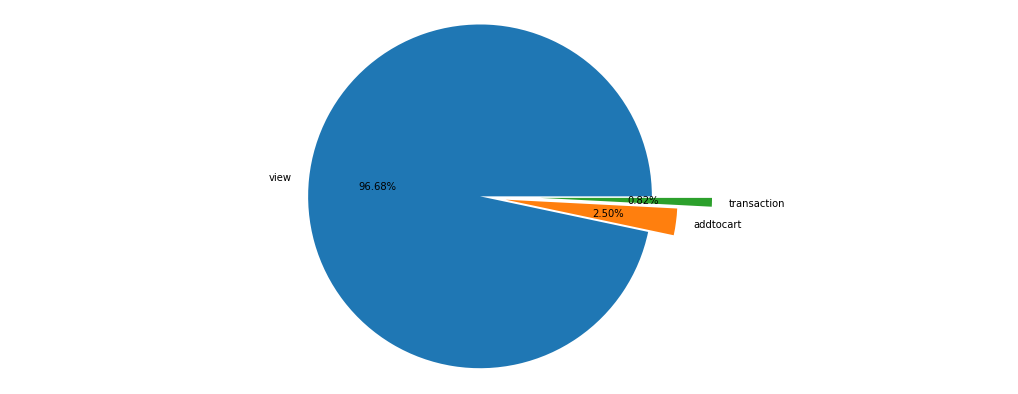

In [150]:
data = events.event.value_counts()
labels = data.index
sizes = data.values
explode = (0, 0.15, 0.35)
fig, ax = plt.subplots(figsize=(18,7))

patches, texts, autotexts = ax.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%', shadow=False, startangle=0) 

ax.axis('equal')
plt.show()

Most of logged interactions are views only. Let's see if there is a time-component to these interaction categories.

Text(0.5, 1.0, 'Time Plot showing AddToCart and Successful Transactions')

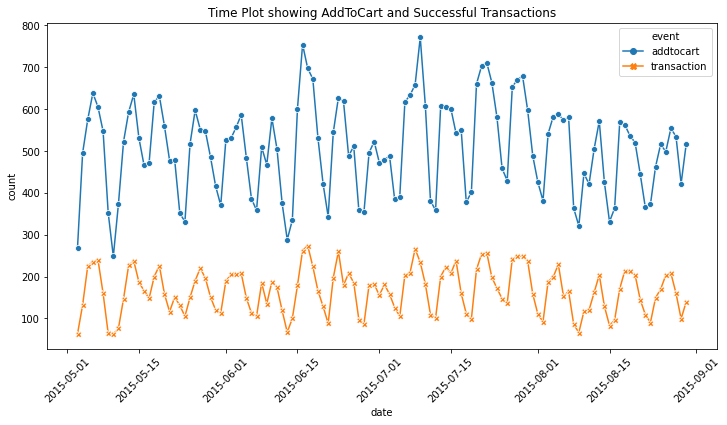

In [151]:
# events['timestamp'].apply(lambda x: x.isoweekday())
tmp = events [['date','event','visitorid']]
tmp = tmp.groupby(['date','event'], as_index = False)['visitorid'].count()
tmp = tmp.rename(columns={'visitorid':'count'})
plt.figure(figsize=(12,6))
ax = sns.lineplot(x="date", y="count",
                  hue="event", style="event",
                  markers=True, dashes=False, data=tmp[tmp['event']!='view'])
plt.xticks(rotation=45)
ax.set_title("Time Plot showing AddToCart and Successful Transactions")


There seems to be a pattern of consisten up and downs. Since we are looking at months, this may be a weekly seasonality. Let's have a look at days of week for same graph as above.

/Users/awaiskaleem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Time Plot showing AddToCart and Successful Transactions - Weekly picture ')

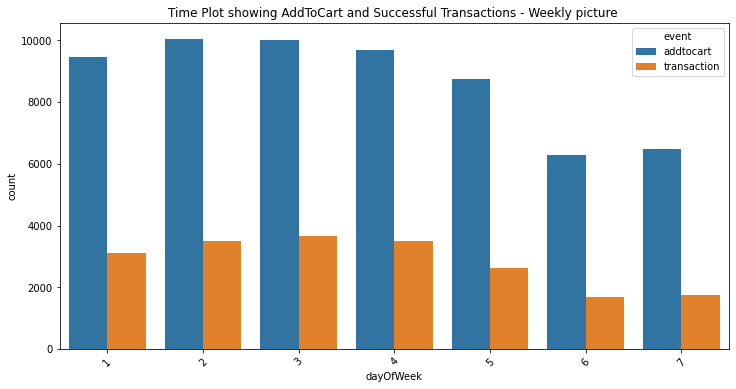

In [157]:
tmp = events [['event','visitorid','timestamp']]
tmp['dayOfWeek'] = tmp['timestamp'].apply(lambda x: x.isoweekday())

tmp = tmp.groupby(['dayOfWeek','event'], as_index = False)['visitorid'].count()
tmp = tmp.rename(columns={'visitorid':'count'})
plt.figure(figsize=(12,6))
ax = sns.barplot(x="dayOfWeek", y="count",
                  hue="event", data=tmp[tmp['event']!='view'])
plt.xticks(rotation=45)
ax.set_title("Time Plot showing AddToCart and Successful Transactions - Weekly picture ")
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

Interesting to see the slight pattern that "addtocart" label peaks at

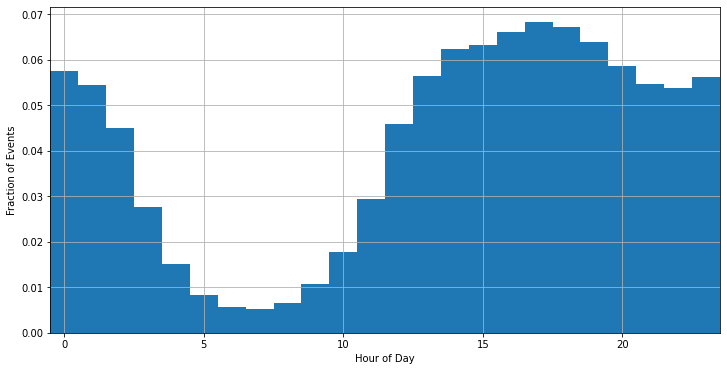

In [95]:
hour = lambda x: (datetime.datetime.fromtimestamp(x)-datetime.timedelta(hours=5)).hour
timestamp = events[['timestamp', 'event']].copy()
timestamp['timestamp'] = timestamp.timestamp / 1000
timestamp['hour'] = timestamp['timestamp'].apply(hour)

timestamp.head()
plt.figure(figsize=(12,6))
timestamp.hour.hist(bins=np.linspace(-0.5, 23.5, 25), alpha=1, density=True)
plt.xlim(-0.5, 23.5)
plt.xlabel("Hour of Day")
plt.ylabel("Fraction of Events")
plt.show()